In [1]:
#download glove model from http://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip and
#upload to bucket

In [1]:
#set random seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
# from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
# import tensorflow_hub as hub

import time
import json

2.3.0


In [2]:
params={
    'image_size': [256, 256],
    'vocab_size': 10000,
    'text_input_length': 49,
    'nodes': 256,
    'tokenizer_start_index': 58, #index of tokenizer to signal sequence start
    'tokenizer_end_index': 57,
    'epochs': 5000,
    'version': 5,
    'embedding_dim': 300,
    'ds_size': 801592
}

In [3]:
training_bucket = 'gs://kds-e7996502fe373b391a0a14641ad5f932ee7d607744dbe970cc8ffe08'
glove_bucket = 'gs://kds-5123f8991f380aa8ec3a0dfae64a3732b529d4e504450dd8f9e55fb1'
tfrecords = tf.io.gfile.glob(training_bucket + '/*tfrecord')

In [4]:
tf.io.gfile.glob(glove_bucket + '/*')


['gs://kds-5123f8991f380aa8ec3a0dfae64a3732b529d4e504450dd8f9e55fb1/glove.840B.300d.txt']

In [5]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.94.61.178:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.94.61.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.94.61.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
def decode_example(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'text': tf.io.FixedLenFeature([], tf.string),
                'inception': tf.io.FixedLenFeature([], tf.string), #can also be vgg
                'y': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    text = tf.cast(text, tf.float32)
    image_features = tf.io.parse_tensor(single_example['inception'], out_type=tf.float32)
    y_value = tf.io.parse_tensor(single_example['y'], out_type=tf.int32)
    y_value = tf.expand_dims(y_value, axis=0)

    return (image_features, text), y_value

In [7]:
def create_ds(files, params):
    '''
    function to create dataset for training/validation
    
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        params: dict with the following keys:
            batch_size: int, batch size of training/validation step
            examples_per_file: int, number of examples in each TFrecord file
        train, bool, default True, indicator if the DS is for training
        test_examples, int: default 1000 number of examples in test dataset
    returns:
        ds: tensorflow input pipeline with images, text and labels
            output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
#     batch_size = 801592
    batch_size = params['ds_size']

    ds = tf.data.TFRecordDataset(filenames = files)
    ds = ds.map(decode_example, 
                num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.batch(batch_size, drop_remainder=True)

#     ds = ds.cache() 
    
    return ds

In [8]:
def download_file(bucket, file_name):
    '''
    downloads a file from a public GCS bucket into working directory

    args:
        bucket: str, name of bucket to download file from
        file_name: str, file name to download
    returns: None
    
    '''
    file_path = tf.io.gfile.glob(bucket + '/' + file_name)[0]
    tf.io.gfile.copy(file_path, file_name)

def create_tokenizer_from_filename(file_name,
                                  bucket=None):
    '''
    creates tf.keras.preprocessing.text.tokenizer from a 
    json config file in current working directory
    args:
        file_name: str, filename where config json file is located
        bucket, str, default None, name of GCS bucket with an object with the
            same file name as glove_file, if an arg
            is passed, function will first check if file_name exists in current
            directory, and if not, will download an object located at file_name
            in the bucket passed into bucket arg
    returns:
        tokenizer object
    '''
    if bucket:
        if not os.path.isfile(file_name):
            download_file(bucket,file_name)
    with open(file_name) as file:
        open_file = json.load(file)
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(open_file)
    return tokenizer

def get_embedding_weights_from_tokenizer_glove(glove_file,
                                              tokenizer,
                                              embedding_dim,
                                              bucket=None,
                                              ):
    '''
    gets the weights to use in an embedding layer from a pretained
    model based on the tokenizer used to create sequences that will
    be passed into embedding layer
    
    args:
        glove_file: str, path of pretrained model from current directory
        tokenizer: tf.keras.preprocessing.text.tokenizer object, tokenizer
            that was used to create sequences
        embedding_dim: int, output_dim of embedding layer of pre-trained model
        bucket, str, default None, name of GCS bucket with an object with the
            same file name as glove_file, if an arg
            is passed, function will first check if glove_file exists in current
            directory, and if not, will download an object located at glove_file
            in the bucket passed into bucket arg
    returns: 
        embedding_weights: numpy array, shaped* (vocab_size, embedding_dim)
            weights that can be used for embedding layer
            *vocab_size = tokenizer.num_words which is the number of words in
            the tokenizer vocabulary
        
    '''
    if bucket:
        if not os.path.isfile(glove_file):
            download_file(bucket, glove_file)
    word_values = dict()
    file = open(glove_file, encoding='utf-8')
    
    for line in file:
        coeff = line.split()
        word = coeff[0]
        coefficients = np.asarray(coeff[-300:], dtype='float32')
        word_values[word] = coefficients
    file.close()
    vocab_size = tokenizer.num_words
    embedding_weights = np.zeros((vocab_size, embedding_dim))
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            word_embedding_values = word_values.get(word)
            if word_embedding_values is not None:
                embedding_weights[idx] = word_embedding_values
    
    return embedding_weights

In [9]:
ds = create_ds(tfrecords, params)

In [10]:
def create_model(params, embedding_weights=None):
    '''
    creates model to caption images
    '''
    vocab_size = params['vocab_size']
    txt_input_length = params['text_input_length']
    nodes = params['nodes']
    embedding_dim = params['embedding_dim']

    image_feature_inp = layers.Input((2048,), name='features_input')
    features = layers.Dropout(0.5)(image_feature_inp)
    features = layers.Dense(nodes)(features)
    features = layers.ReLU()(features)
    
    txt_inp = layers.Input((txt_input_length,), name='text_input')
    embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(txt_inp)
    embedding = layers.Dropout(0.5)(embedding)
    sequences = layers.GRU(nodes)(embedding)

    decoder = layers.Add()([features, sequences]) # Concatenate - try
    decoder = layers.Dense(nodes, activation=None)(decoder)
    decoder = layers.ReLU()(decoder)
    output = layers.Dense(vocab_size, activation='softmax')(decoder)
    model = keras.Model([image_feature_inp, txt_inp], output)
    model.layers[3].set_weights([embedding_weights])
    model.layers[3].trainable = False

    return model

In [11]:
tokenizer = create_tokenizer_from_filename('coco_tokenizer.json', 
                                           training_bucket)
embedding_weights = get_embedding_weights_from_tokenizer_glove('glove.840B.300d.txt',
                                                               tokenizer,
                                                               300,
                                                               glove_bucket)

In [12]:
with strategy.scope():
    model = create_model(params, embedding_weights) #embedding_weights
    model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy')

In [13]:
for input_data, ground_truth in ds:
    history = model.fit(input_data, ground_truth, steps_per_epoch=150, epochs=50)

Epoch 1/50
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  1/150 [..............................] - ETA: 6:50 - loss: 9.2213WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.0375s). Check your callbacks.


150/150 [==============================] - 11s 70ms/step - loss: 4.7383
Epoch 2/50
150/150 [==============================] - 5s 37ms/step - loss: 3.3999
Epoch 3/50
150/150 [==============================] - 6s 37ms/step - loss: 3.0614
Epoch 4/50
150/150 [==============================] - 6s 37ms/step - loss: 2.8873
Epoch 5/50
150/150 [==============================] - 6s 37ms/step - loss: 2.7752
Epoch 6/50
150/150 [==============================] - 6s 37ms/step - loss: 2.6900
Epoch 7/50
150/150 [==============================] - 6s 38ms/step - loss: 2.6236
Epoch 8/50
150/150 [==============================] - 6s 38ms/step - loss: 2.5698
Epoch 9/50
150/150 [==============================] - 6s 37ms/step - loss: 2.5205
Epoch 10/50
150/150 [==============================] - 6s 37ms/step - loss: 2.4786
Epoch 11/50
150/150 [==============================] - 6s 37ms/step - loss: 2.4440
Epoch 12/50
150/150 [==============================] - 6s 37ms/step - loss: 2.4120
Epoch 13/50
150/150 [==

In [14]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

client = storage.Client(project='hateful-memes', credentials=credentials)

In [15]:
model_num = params['version']
model_path = 'image_caption_model_v{}.h5'.format(model_num)
model.save(model_path)
model_bucket = client.bucket('jh_hateful_memes')
blob = model_bucket.blob(model_path)
blob.upload_from_filename(model_path)

In [16]:
def get_image_captions(params, images):
    '''
    creates captions to a group of images
    
    args:
        params: dictionary with at least the following keys:
            caption_text_input_length: int, length of captions
            tokenizer_start_index: int, value to signal start of caption
            tokenizer_end_index: int, value to signal end of caption
            
        images: tensor, dtype: tf.float32 shaped (None, 299, 299, 3) None is the 
        number of images, each image should be normalized to have
        pixel values of -1 to 1. Images to be captioned

            
    returns:
        captions: tensor, dtype float, shaped 
        (None, params['caption_text_input_length'])None is the number of 
        images, image caption sequences
    '''
    num_images = len(images)
    caption_len = params['text_input_length']
    caption_end_index = params['tokenizer_end_index']

    @tf.function
    def get_capt(img, txt):
        def caption_step(image_, text_):
            '''
            evaluate model here
            '''
            txt_ = tf.expand_dims(text_, axis=0)
            pred = model((image_, txt_))


            return pred
        result = strategy.run(caption_step, args=(img, txt))
        return result

    
    captions = list()
    for image in range(num_images):
        img = images[image]
        img = tf.expand_dims(img, axis=0)
        txt_input = np.zeros((caption_len))
        result = params['tokenizer_start_index']
        for idx in range(caption_len):
            txt_input[idx] = result
            # with tf.device('/TPU:0'):
            #     result = caption_step(img, txt_input)
                # result = strategy.run(caption_step, args=(img, txt_input))
            result = get_capt(img, txt_input)
            result = result.numpy()[0] # result.values[0].numpy()[0]
            result = tf.argmax(result, axis=0)
            if result == caption_end_index:
                break
        captions.append(txt_input)
    captions = tf.convert_to_tensor(captions)
    return captions

In [17]:
def plot_metric(metric1, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    # plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

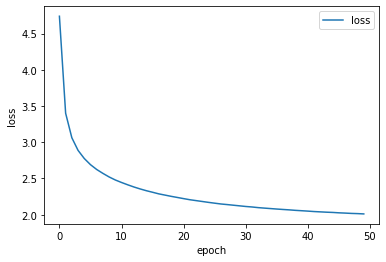

In [18]:
plot_metric('loss', 'loss')

In [19]:
min(history.history['loss'])

2.0102853775024414